In [113]:
import numpy as np
import matplotlib.pyplot as plt 
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from astropy.time import Time
import astropy.units as u
import pandas as pd
from numpy.random import rand
from math import factorial
import scipy.optimize 
import emcee
import corner
from IPython.display import display, Math
from scipy.optimize import minimize

plt.rcParams['mathtext.fontset'], plt.rcParams['font.family'] = 'stix', 'STIXGeneral'
plt.rcParams.update({'font.size': 16})

## McGill Magnetar Catalog:

Determining which magnetars are visible to STARE2 and for how long. This will be used when later working on model corrections that take into account the look-elsewhere effect.

In [2]:
df = pd.read_csv('Data/McGill_magnetar_catalog.csv')

NAMES = df['Name']
RA = df['RA']
DEC = df['Decl']

In [3]:
mags = [SkyCoord(RA[i] + ' ' + DEC[i], unit=(u.hourangle, u.deg)) for i in np.arange(len(RA))]

In [4]:
# Coords for OVRO
LAT, LON, ALT = 37.23, 118.28, 1222
OVRO = EarthLocation(lat=LAT, lon=LON, height=ALT)
FOV = 90-35 # degrees

PST = -7*u.hour
time = Time('2022-8-10 12:00:00') + PST
midnight = Time('2022-8-10 00:00:00') + PST # Change date for today's visability
hours = np.linspace(12, 38, 500)*u.hour
# hours = np.linspace(0, 24, 100)*u.hour

mags_altaz = [mags[i].transform_to(AltAz(obstime=midnight+hours, location=OVRO)) for i in np.arange(len(mags))]

In [5]:
mags_alts = [mags_altaz[i].alt.value for i in np.arange(len(mags_altaz))]
mags_azs = [mags_altaz[i].az.value for i in np.arange(len(mags_altaz))]

In [6]:
len(np.arange(0, len(mags_alts)))

31

In [7]:
SGR1935 = np.argwhere([NAMES[i] == 'SGR 1935+2154' for i in np.arange(len(NAMES))])[0][0]

lws = [1.5]*len(NAMES)
lws[SGR1935] = 5.0


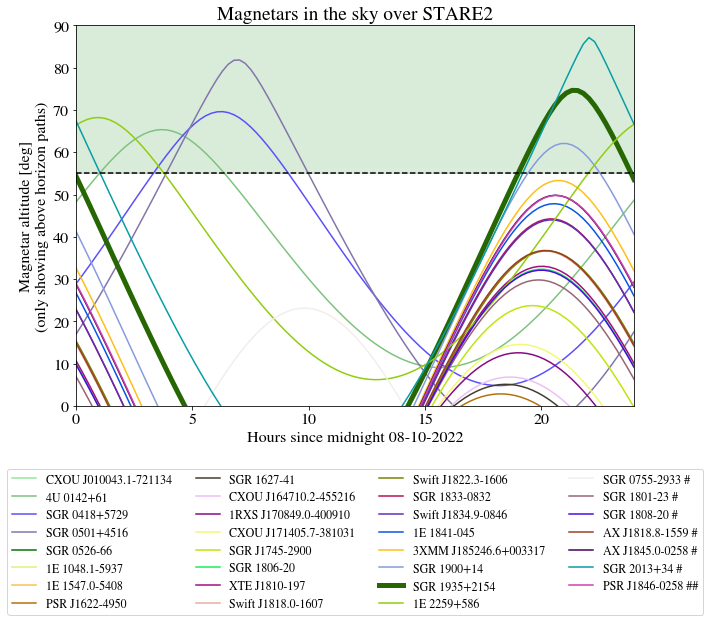

In [79]:
plt.figure(figsize=(10,7))
paths = []
for i in np.arange(0, len(mags_alts)):
    icolor=rand(3)
    path = plt.plot(hours, mags_alts[i], color=icolor, label=NAMES[i], lw=lws[i])
    paths.append(path)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4, fontsize=12)
plt.xlabel('Hours since midnight 08-10-2022')
plt.ylabel('Magnetar altitude [deg]\n(only showing above horizon paths)')
plt.margins(x=0, y=0.01)
plt.ylim(0, 90)
plt.title('Magnetars in the sky over STARE2')

horizon = plt.hlines(FOV, min(hours.value), max(hours.value), 'k', linestyles='dashed', label='STARE2 alt. limit', zorder=32)
range = plt.fill_between(hours.value, FOV, 95, zorder=0, alpha=0.15, color='green', label='STARE2 observable')
# paths = np.array(paths)
# legend1 = plt.legend(handles=[paths[i] for i in np.arange(len(paths))], 
#                      loc='upper center', 
#                      bbox_to_anchor=(0.5, -0.15), 
#                      ncol=4, 
#                      fontsize=12)
# plt.gca().add_artist(legend1)
# legend2 = plt.legend(handles=[horizon, range], loc='upper left', bbox_to_anchor=(1,1), fontsize=13)


plt.show();

In [8]:
mag_alts = np.array(mags_alts)
mag_alts.shape

def visible():
    results = []
    for mag in np.arange(len(mag_alts)):
        for i in mag_alts[mag]:
            if i < 55:
                results.append(0)
            elif i > 55:
                results.append(1)
    return results

In [9]:
vis = visible()
vis = np.reshape(vis, (31, 500))

In [10]:
observable_mags = []
nonobservable_mags = []
for i in np.arange(len(vis)):
    if np.any(vis[i]==1):
        observable_mags.append(i)
    elif np.all(vis[i]==0):
        nonobservable_mags.append(i)

In [12]:
print('Number of magnetars observable by STARE2:', len(observable_mags))

Number of magnetars observable by STARE2: 7


In [13]:
print('The magnetars visible to STARE2:\n', NAMES[observable_mags])

The magnetars visible to STARE2:
 1        4U 0142+61
2     SGR 0418+5729
3     SGR 0501+4516
21      SGR 1900+14
22    SGR 1935+2154
23      1E 2259+586
29    SGR 2013+34 #
Name: Name, dtype: object


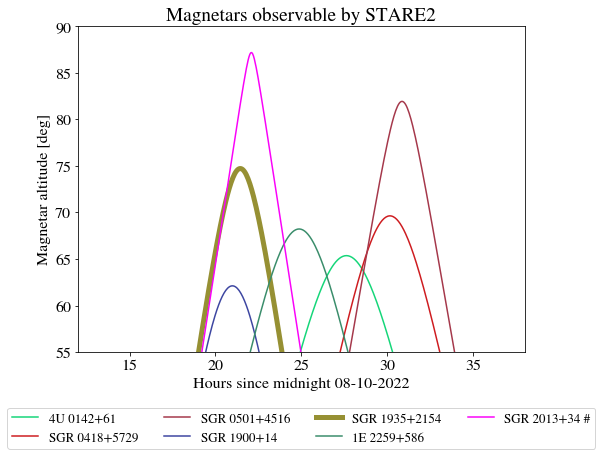

In [14]:
plt.figure(figsize=(8,6))
for i in observable_mags:
    icolor=rand(3)
    plt.plot(hours, mags_alts[i], color=icolor, label=NAMES[i], lw=lws[i])
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4, fontsize=13)
plt.xlabel('Hours since midnight 08-10-2022')
plt.ylabel('Magnetar altitude [deg]')
plt.margins(x=0, y=0.01)
plt.ylim(FOV, 90)
plt.title('Magnetars observable by STARE2')

# horizon = plt.hlines(FOV, min(hours.value), max(hours.value), 'k', linestyles='dashed', label='STARE2 alt. limit', zorder=32)
# range = plt.fill_between(hours.value, FOV, 90, zorder=0, alpha=0.15, color='green', label='STARE2 observable')

plt.show();

In [15]:
above_FOV = []

for i in np.arange(len(observable_mags)):
    intercepts = np.array([np.argwhere(mag_alts[observable_mags[i]]>FOV)[0], np.argwhere(mag_alts[observable_mags[i]]>FOV)[-1]])
    above_FOV.append(intercepts)


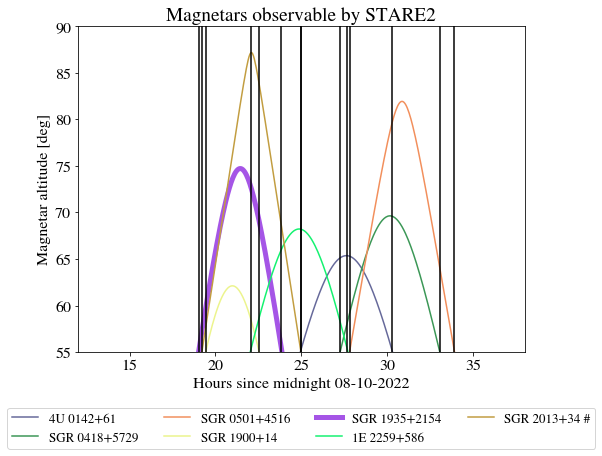

In [16]:
plt.figure(figsize=(8,6))
for i in observable_mags:
    icolor=rand(3)
    plt.plot(hours, mags_alts[i], color=icolor, label=NAMES[i], lw=lws[i])
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4, fontsize=13)
plt.xlabel('Hours since midnight 08-10-2022')
plt.ylabel('Magnetar altitude [deg]')
plt.margins(x=0, y=0.01)
plt.ylim(FOV, 90)
plt.title('Magnetars observable by STARE2')
for i in np.arange(len(above_FOV)):
    plt.vlines(hours[above_FOV[i]].value, FOV, 90, 'k')
# plt.vlines(hours[above_FOV[0][0][0]].value, FOV, 90, 'k')
# plt.vlines(hours[above_FOV[1]].value, FOV, 90, 'k')

plt.show();

In [17]:
observable_time = []

for i in np.arange(len(observable_mags)):
    time = np.abs(np.subtract(*hours[above_FOV[i]].value))
    observable_time.append(time)
observable_time # hours/day

[array([5.31462926]),
 array([5.78356713]),
 array([6.04408818]),
 array([3.0741483]),
 array([4.79358717]),
 array([5.62725451]),
 array([5.73146293])]

## Poisson analysis

### STARE2

In [18]:
def λ(r, t):
    return r*t

R_STARE2 = 4.19 # yr^-1 --- MJy ms fluence FRB rate from SGR1935 (computed in 'rates_vs_fluence_estimates.ipynb')
t_obs = 2090.667 # hrs -- total obs. time (computed in 'rates_vs_fluence_estimates.ipynb')
T_STARE2 = (t_obs/(24))*np.sum(observable_time) # hrs
print(T_STARE2)

λ_STARE2 = λ(R_STARE2, T_STARE2)/8760 # divide by hrs/yr
λ_STARE2 # unitless

3168.121636272545


1.5153458511394937

In [19]:
from scipy.stats import poisson

ks_STARE2 = np.arange(0, 11)
dist_STARE2 = poisson.pmf(ks_STARE2, mu=λ_STARE2)

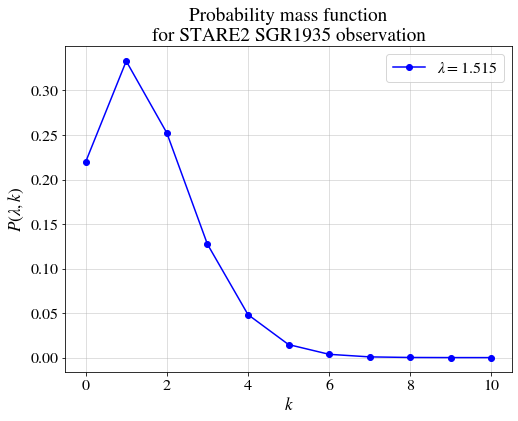

In [20]:
plt.figure(figsize=(8,6))
plt.plot(ks_STARE2, dist_STARE2, 'bo-', label='$λ = {0:.3f}$'.format(λ_STARE2))
plt.title('Probability mass function\nfor STARE2 SGR1935 observation')
plt.ylabel('$P(λ, k)$', fontsize=17)
plt.xlabel('$k$', fontsize=17)
plt.legend()
plt.grid(alpha=0.5)
plt.show()

### Kirsten et al.

In [21]:
T_euro = 522.7 # hrs
R_euro = 33.5 # yr^-1 --- Jy ms rate from SGR1935 (computed in 'rates_vs_fluence_estimates.ipynb')

λ_euro = λ(R_euro, T_euro)/8760 # divide by hrs/yr
λ_euro # unitless

1.9989098173515982

In [22]:
ks_euro = np.arange(0, 11)
dist_euro = poisson.pmf(ks_euro, mu=λ_euro)

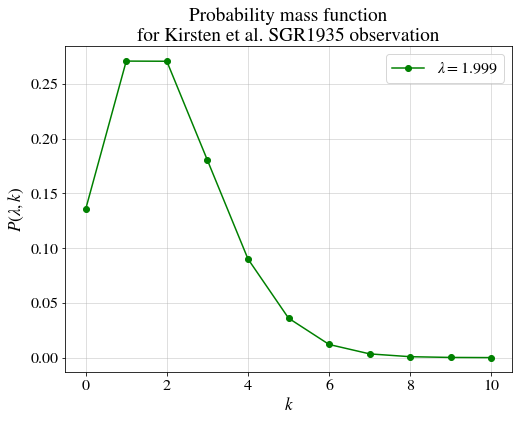

In [23]:
plt.figure(figsize=(8,6))
plt.plot(ks_euro, dist_euro, 'go-', label='$λ = {0:.3f}$'.format(λ_euro))
plt.title('Probability mass function\nfor Kirsten et al. SGR1935 observation')
plt.ylabel('$P(λ, k)$', fontsize=17)
plt.xlabel('$k$', fontsize=17)
plt.legend()
plt.grid(alpha=0.5)

<Figure size 432x288 with 0 Axes>

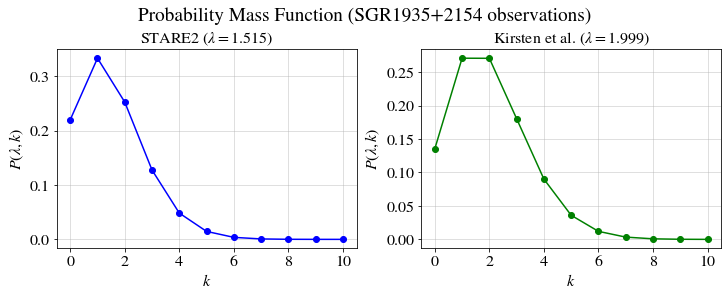

In [24]:
plt.figure()
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10,4), constrained_layout=True)
ax0.plot(ks_STARE2, dist_STARE2, 'bo-')
ax1.plot(ks_euro, dist_euro, 'go-')
ax0.set_ylabel('$P(λ, k)$', fontsize=16)
ax1.set_ylabel('$P(λ, k)$', fontsize=16)
ax0.set_xlabel('$k$', fontsize=16)
ax1.set_xlabel('$k$', fontsize=16)
ax0.grid(alpha=0.5), ax1.grid(alpha=0.5)
plt.suptitle('Probability Mass Function (SGR1935+2154 observations)')

ax0.set_title('STARE2 ($λ = {0:.3f}$)'.format(λ_STARE2), fontsize=16)
ax1.set_title('Kirsten et al. ($λ = {0:.3f}$)'.format(λ_euro), fontsize=16)

plt.show()

In [25]:
σ_STARE2 = np.sqrt(λ_STARE2)
σ_euro = np.sqrt(λ_euro)

print('STARE2 STD:', σ_STARE2, '\nKirsten et al. STD:', σ_euro)

STARE2 STD: 1.2309938469137423 
Kirsten et al. STD: 1.4138280720623702


<Figure size 432x288 with 0 Axes>

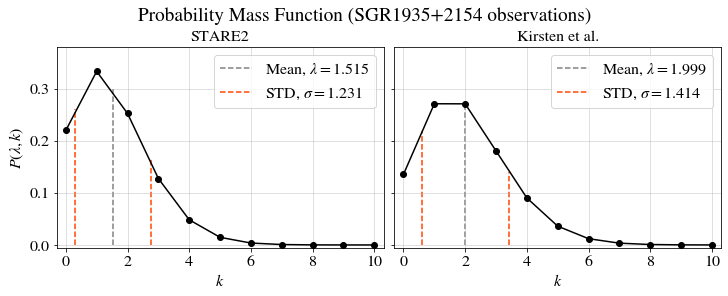

In [26]:
plt.figure()
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10,4), constrained_layout=True, sharey=True)
ax0.plot(ks_STARE2, dist_STARE2, 'ko-')
ax1.plot(ks_euro, dist_euro, 'ko-')
ax0.set_ylabel('$P(λ, k)$', fontsize=16)
# ax1.set_ylabel('$P(λ, k)$', fontsize=16)
ax0.set_xlabel('$k$', fontsize=16)
ax1.set_xlabel('$k$', fontsize=16)
ax0.grid(alpha=0.5), ax1.grid(alpha=0.5)
plt.suptitle('Probability Mass Function (SGR1935+2154 observations)')

ax0.set_title('STARE2', fontsize=16)
ax1.set_title('Kirsten et al.', fontsize=16)

ax0.vlines(λ_STARE2, 0, 0.30, 'grey', linestyles='dashed', label='Mean, $λ={0:.3f}$'.format(λ_STARE2), zorder=1)
ax0.vlines(λ_STARE2-σ_STARE2, 0, 0.26, 'orangered', linestyles='dashed', label='STD, $σ={0:.3f}$'.format(σ_STARE2), zorder=1)
ax0.vlines(λ_STARE2+σ_STARE2, 0, 0.165, 'orangered', linestyles='dashed', zorder=1)
ax0.legend()

ax1.vlines(λ_euro, 0, 0.27, 'grey', linestyles='dashed', label='Mean, $λ={0:.3f}$'.format(λ_euro), zorder=1)
ax1.vlines(λ_euro-σ_euro, 0, 0.218, 'orangered', linestyles='dashed', label='STD, $σ={0:.3f}$'.format(σ_euro), zorder=1)
ax1.vlines(λ_euro+σ_euro, 0, 0.14, 'orangered', linestyles='dashed', zorder=1)
ax1.legend()

ax0.margins(y=0.02, x=0.03)
ax1.margins(y=0.02, x=0.03)

ax0.set_ylim(top=0.38)
# ax1.set_ylim(top=0.40)
plt.show()

### Make a function of rate (R)

In [27]:
R_range_STARE2 = np.linspace(0, 25, 1000)
R_range_euro = np.linspace(0, 200, 1000)

T_STARE2_yrs = T_STARE2/8760
T_euro_yrs = T_euro/8760

print(T_STARE2_yrs, T_euro_yrs)

0.36165772103567867 0.0596689497716895


Normalization constants A were determined by solving the following integral for each observation (STARE2 and Kirsten et al.):
$1 = \int_0^\infty A P(R)dR$

Furthermore, the median was manually solved for by solving the following integral:
$\frac{1}{2} = \int_{R_{med}}^\infty A P(R)dR$

In [28]:
# Normalization constants -- UNITLESS
A_STARE2 = T_STARE2_yrs
A_euro = T_euro_yrs 

# Median values
R_median_STARE2 = 4.641
R_median_euro = 44.815

k_STARE2 = 1
k_euro = 2

In [29]:
def P(A, R, T, k):
    a = (R*T)**k
    b = np.exp(-R*T)
    c = factorial(k)
    return A*(a*b)/c

prob_dist_STARE2 = P(A_STARE2, R_range_STARE2, T_STARE2_yrs, k_STARE2)
prob_dist_euro = P(A_euro, R_range_euro, T_euro_yrs, k_euro)

The standard deviation ($1\sigma$) is computed by integrating to 16% and 84% for the lower and upper bounds.

$0.16 = \int_{R_{med}}^\infty A P(R)dR$

$0.84 = \int_{R_{med}}^\infty A P(R)dR$

Once again, these integrals are solved numerically.

In [266]:
# 1σ  R values
minus_std_STARE2 = 1.969
plus_std_STARE2 = 9.093

minus_std_euro = 23.009
plus_std_euro = 77.511


# 1σ values
plus_1σ_STARE2 = plus_std_STARE2 - R_median_STARE2 
minus_1σ_STARE2 = R_median_STARE2 - minus_std_STARE2

plus_1σ_euro = plus_std_euro - R_median_euro
minus_1σ_euro = R_median_euro - minus_std_euro

<Figure size 432x288 with 0 Axes>

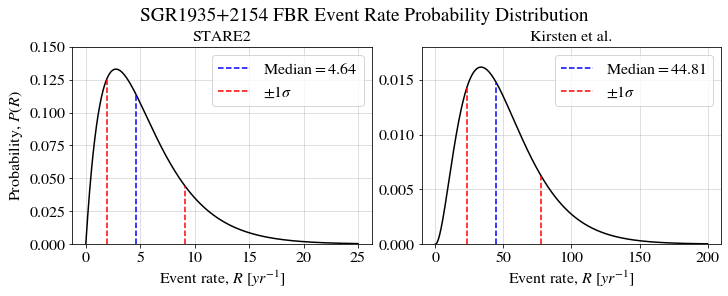

In [31]:
plt.figure()
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10,4), constrained_layout=True, sharey=False)
ax0.plot(R_range_STARE2, prob_dist_STARE2, 'k-')
ax1.plot(R_range_euro, prob_dist_euro, 'k-')

ax0.set_ylabel('Probability, $P(R)$', fontsize=16)

ax0.set_xlabel('Event rate, $R$ $[yr^{-1}]$', fontsize=16)
ax1.set_xlabel('Event rate, $R$ $[yr^{-1}]$', fontsize=16)

ax0.grid(alpha=0.5), ax1.grid(alpha=0.5)
plt.suptitle('SGR1935+2154 FBR Event Rate Probability Distribution')

ax0.set_title('STARE2', fontsize=16)
ax1.set_title('Kirsten et al.', fontsize=16)

ax0.vlines(R_median_STARE2, 0, P(A_STARE2, R_median_STARE2, T_STARE2_yrs, k_STARE2), color='blue', linestyles='dashed', zorder=3, label='Median$ = {0:.2f}$'.format(R_median_STARE2))
ax0.vlines(plus_std_STARE2, 0, P(A_STARE2, plus_std_STARE2, T_STARE2_yrs, k_STARE2), color='red', linestyles='dashed', zorder=3, label='$\pm1σ$')
ax0.vlines(minus_std_STARE2, 0, P(A_STARE2, minus_std_STARE2, T_STARE2_yrs, k_STARE2), color='red', linestyles='dashed', zorder=3)

ax1.vlines(R_median_euro, 0, P(A_euro, R_median_euro, T_euro_yrs, k_euro), color='blue', linestyles='dashed', zorder=3, label='Median$ = {0:.2f}$'.format(R_median_euro))
ax1.vlines(plus_std_euro, 0, P(A_euro, plus_std_euro, T_euro_yrs, k_euro), color='red', linestyles='dashed', zorder=3, label='$\pm1σ$')
ax1.vlines(minus_std_euro, 0, P(A_euro, minus_std_euro, T_euro_yrs, k_euro), color='red', linestyles='dashed', zorder=3)

ax0.legend()
ax1.legend()

ax0.margins(y=0)
ax0.set_ylim(top=0.15)
ax1.margins(y=0)
ax1.set_ylim(top=0.018)

plt.show()

## Rate vs. Fluences

### Without the look-elsewhere effect:

Reproduced from 'rates_vs_fluence_estimates.ipynb'.

In [32]:
STARE2_FWHM = 70 # degrees

STARE2_SGR1935_time = (STARE2_FWHM/360)*24 # hr/day

STARE2_obs_days = 448 # days

STARE2_tot_obs_time = STARE2_SGR1935_time*STARE2_obs_days # hrs
print('Total obs time of SGR1935 by STARE2:', STARE2_tot_obs_time)

Total obs time of SGR1935 by STARE2: 2090.666666666667


In [33]:
annual_hours = 8760 # hrs/year
MJy_rate = annual_hours/STARE2_tot_obs_time

print('MJy ms fluence FRB rate from SGR1935:', MJy_rate)

MJy ms fluence FRB rate from SGR1935: 4.190051020408163


In [157]:
# # Obs. data
# obs_rate_pnts = [33.5, 4.19]
# obs_fluence_pnts = np.log10([1e2, 1.5e6])

In [164]:
# def exp_model(x, A, b):
#     return A*10**(b*x)

# guesses = np.array([1, -.01])
# opt, cov = scipy.optimize.curve_fit(exp_model, obs_fluence_pnts, obs_rate_pnts, guesses) 
# # print('A, b = {param:.3f}'.format(param=opt))
# print('A, b = {0:.3f}, {1:.3f}'.format(opt[0], opt[1]));

In [165]:
# plt.figure(figsize=(7,5))

# plt.title('OLD MODEL')

# obs_labels = ['Kirsten et al. (2021)', 'CHIME + STARE2 (2020)']
# obs_markers = ['s', '^']
# for i in np.arange(len(obs_rate_pnts)):
#     plt.semilogy(obs_fluence_pnts[i], obs_rate_pnts[i], 'k', marker=obs_markers[i], 
#              label=obs_labels[i], markersize=8, linestyle='None')
# xs = np.linspace(*np.log10([1e0, 1e7])) 
# plt.plot(xs, exp_model(xs, *opt), 'b--', zorder=1, 
#          label='Model: $y=A\cdot10^{Bx}$'+'\n[A, B] = [{0:.3f}, {1:.3f}]'.format(opt[0], opt[1]))

# plt.xlabel('Fluence, $\mathcal{\log{F}}$  [Jy$\cdot$ms]')
# plt.ylabel('FRB event rate,\nR($>\mathcal{F}$)  [yr$^{-1}$]')

# plt.plot(3, exp_model(3, *opt), marker='*', markersize=13, c='orangered', label='kJy$\cdot$ms FRB', linestyle='None')

# plt.legend(bbox_to_anchor=(1,1), loc='upper left')
# plt.grid()

# plt.show()

### With the look-elsewhere effect:

In [267]:
obs_rate_LEE = np.log10([R_median_euro, R_median_STARE2])
obs_fluence_pnts = np.log10([1e2, 1.5e6])
# sigmas = np.log10([[minus_1σ_euro, plus_1σ_euro], [minus_1σ_STARE2, plus_1σ_STARE2]])
rate_err = [np.log10([R_median_euro+plus_1σ_euro, R_median_euro-minus_1σ_euro]), np.log10([R_median_STARE2+plus_1σ_STARE2, R_median_STARE2-minus_1σ_STARE2])]
pm_err = [np.abs(obs_rate_LEE[i]-rate_err[i]) for i in range(2)]
pm_err

[array([0.23793994, 0.28952566]), array([0.29209562, 0.37236585])]

In [202]:
# # guesses = np.array([1, -.01])
# opt_new, cov_new = scipy.optimize.curve_fit(exp_model, obs_fluence_pnts, obs_rate_LEE, guesses) 
# # print('A, b = {param:.3f}'.format(param=opt))
# print('A, b = {0:.3f}, {1:.3f}'.format(opt_new[0], opt_new[1]));

In [167]:
# ## Comparing previous model to new model ##
# plt.figure(figsize=(7,5))

# plt.title('COMPARING NEW MODEL TO OLD MODEL')

# obs_labels = ['Kirsten et al. (2021)', 'STARE2 (2020)']
# obs_markers = ['s', '^']
# for i in np.arange(len(obs_rate_LEE)):
#     plt.errorbar(obs_fluence_pnts[i], obs_rate_LEE[i], yerr=np.array([rate_err[i]]).T, color='k', capsize=3,
#                  marker=obs_markers[i], label=obs_labels[i], markersize=8, linestyle='None')
#     plt.semilogy(obs_fluence_pnts[i], obs_rate_pnts[i], color='grey', marker=obs_markers[i],
#                  markersize=8, linestyle='None', alpha=0.6)
# xs = np.linspace(*np.log10([1e0, 1e7])) 
# plt.plot(xs, exp_model(xs, *opt), color='grey', linestyle='--', alpha=0.6, zorder=1)
# plt.plot(xs, exp_model(xs, *opt_new), color='blue', linestyle='dashed', zorder=1, 
#         label='Model: $y=A\cdot10^{Bx}$'+'\n[A, B] = [{0:.3f}, {1:.3f}]'.format(opt_new[0], opt_new[1]))

# plt.xlabel('Fluence, $\mathcal{\log{F}}$  [Jy$\cdot$ms]')
# plt.ylabel('FRB event rate,\nR($>\mathcal{F}$)  [yr$^{-1}$]')

# # plt.plot(3, exp_model(3, *opt), marker='*', markersize=13, color='gold', linestyle='None', alpha=0.6)
# plt.plot(3, exp_model(3, *opt_new), marker='*', markersize=13, color='orangered', linestyle='None', label='kJ$\cdot$ms target FRB')

# plt.legend(bbox_to_anchor=(1,1), loc='upper left')
# # plt.grid()

# plt.show()

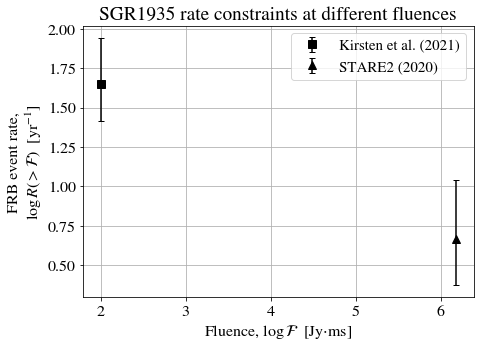

In [268]:
### Can't plot best fit line just yet -- above BFL was for visual reference ###

plt.figure(figsize=(7,5))

plt.title('SGR1935 rate constraints at different fluences')

obs_labels = ['Kirsten et al. (2021)', 'STARE2 (2020)']
obs_markers = ['s', '^']
for i in range(2):
    plt.errorbar(obs_fluence_pnts[i], obs_rate_LEE[i], yerr=np.array([pm_err[i]]).T, color='k', capsize=3,
                 marker=obs_markers[i], label=obs_labels[i], markersize=8, linestyle='None')
# plt.yscale('log')

# plt.plot(obs_fluence_pnts[0], obs_rate_LEE[0], 'ko')
# plt.plot(obs_fluence_pnts[0], obs_rate_LEE[0]+plus_1σ_euro, 'k.')

# plt.ylim(top=2e2)
# plt.xlim(left=1, right=7)

plt.xlabel('Fluence, $\mathcal{\log{F}}$  [Jy$\cdot$ms]')
plt.ylabel('FRB event rate,\n$\log{R(>\mathcal{F}}$)  [yr$^{-1}$]')

plt.legend(loc='upper right', fontsize=15)
plt.grid()

plt.show()

## MCMC

Reference: https://emcee.readthedocs.io/en/stable/tutorials/line/

In [269]:
# Compute the mean of the above probability distributions
euro_args = np.argwhere(np.isclose(prob_dist_euro, np.mean(prob_dist_euro), atol=1e-4)==True)
print(euro_args)
R_euro_mean = R_range_euro[417]
print(R_euro_mean, prob_dist_euro[417], np.mean(prob_dist_euro))

STARE2_args = np.argwhere(np.isclose(prob_dist_STARE2, np.mean(prob_dist_STARE2), atol=1e-5)==True)
print(STARE2_args)
R_STARE2_mean = R_range_STARE2[380]
R_STARE2_mean
print(R_STARE2_mean, prob_dist_STARE2[380], np.mean(prob_dist_STARE2))

[[ 45]
 [417]
 [418]
 [419]
 [420]
 [421]
 [422]]
83.48348348348348 0.005081992659282247 0.004992254829493755
[[380]]
9.50950950950951 0.03991475151224925 0.03991241189330552


In [274]:
### [EURO, STARE2]
R_meds = np.log10([R_median_euro, R_median_STARE2])
F_meds = np.log10([1e2, 1.5e6])
R_means = np.log10([R_euro_mean, R_STARE2_mean])

In [271]:
def log_likelihood(theta, R, F, R_μ):
    m, b = theta
    model = m*R + b
    sigma2 = (R-R_μ)**2 # variance
    L = -0.5*np.sum((F-model)**2/sigma2 + np.log(2*np.pi*sigma2))
    return L

In [279]:
nll = lambda *args: -log_likelihood(*args) 
# maximizing the likelihood is the same as minimizing the negative of the liklihood

initial = np.array([-0.25, 2])
soln = minimize(nll, initial, args=(R_meds, F_meds, R_means))
m_ml, b_ml = soln.x # maximum likelihood values
print('Maximum likelihood values:', soln.x)

Maximum likelihood values: [-4.24049666  9.00285538]


In [280]:
def log_prior(theta): # sets up priors on theta
    m, b = theta
    if -2 < m < 1 and 0 < b < 10:
        return 0.0
    return -np.inf

In [281]:
def log_probability(theta, R, F, R_μ):
    lp = log_prior(theta) 
    if not np.isfinite(lp): 
        return -np.inf
    return lp + log_likelihood(theta, R, F, R_μ)

In [ ]:
pos = soln.x + 1e-2 * np.random.randn(50, 2)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers,
                                ndim, 
                                log_probability, 
                                args=(R_meds, F_meds, R_means))


sampler.run_mcmc(pos, 10000, progress=True);

  0%|                                   | 0/10000 [00:00<?, ?it/s]/home/darbymccauley/.local/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
 38%|████████▋              | 3789/10000 [00:05<00:08, 766.59it/s]

In [143]:
samples = sampler.get_chain()

tau = sampler.get_autocorr_time()
print('Integrated autocorrelation time:', tau)

/home/darbymccauley/.local/lib/python3.9/site-packages/emcee/autocorr.py:38: RuntimeWarning: invalid value encountered in true_divide
  acf /= acf[0]


Integrated autocorrelation time: [nan nan]


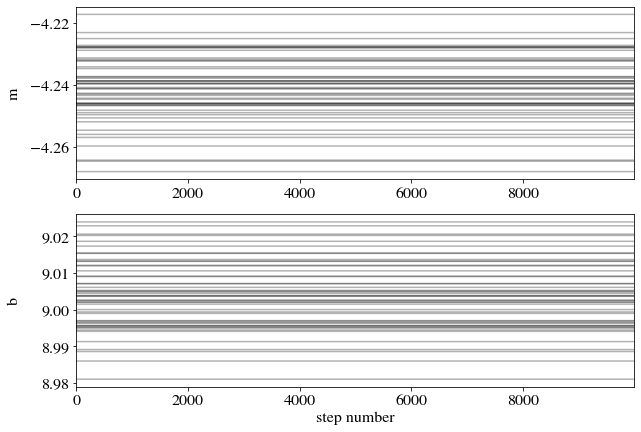

In [144]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=False)
labels = ['m', 'b']
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples)-1)
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel('step number');
